In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from matplotlib import style 
import seaborn as sns
style.use('default')

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/myra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
import sys
sys_path = sys.path.copy()
sys.path.append('../')
import utils
sys.path = sys_path

Table of contents:
* [Correlation](#Correlation)
* [Desciptives for Data](#Desciptives-for-Data)

## Read Data

In [31]:
# the news articles
articles = utils.load_articles(data_root_folder="../data/")

# dev and train data
data_train, data_dev = utils.load_data(data_root_folder="../data/")

# sentencized automatic emotion tags
sent_emotion_train, sent_emotion_dev = utils.load_articles(data_root_folder="../data/")

In [32]:
# tokenized version of the text
data_train['essay_tok'] = data_train['essay'].apply(lambda x: nltk.word_tokenize(x))
articles['text_tok'] = articles['text'].apply(lambda x: nltk.word_tokenize(x))

# Show Data
Dev data does not have the features *empathy_bin* and *distress_bin*, therefore we can exclude them.

In [33]:
print(data_train.shape)
data_train[:3]

(1860, 24)


,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,...,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern,essay_tok
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,...,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0,"[it, is, really, diheartening, to, read, about..."
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,...,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0,"[the, phone, lines, from, the, suicide, preven..."
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,...,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0,"[no, matter, what, your, heritage, ,, you, sho..."


In [34]:
print(data_dev.shape)
data_dev[:3]

(270, 21)


,message_id,response_id,article_id,essay,gender,education,race,age,income,empathy,...,emotion,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
0,R_3QLVVnAgRBRH41U_1,R_3QLVVnAgRBRH41U,13,The story about the air strikes is very sadden...,1.0,4.0,3.0,20.0,24000.0,7.000,...,sadness,5.5,5.5,4.0,5.0,4.5,4.429,2.286,4.143,3.143
1,R_3QLVVnAgRBRH41U_2,R_3QLVVnAgRBRH41U,127,It is clear that climate change is something t...,1.0,4.0,3.0,20.0,24000.0,3.167,...,sadness,5.5,5.5,4.0,5.0,4.5,4.429,2.286,4.143,3.143
2,R_3QLVVnAgRBRH41U_3,R_3QLVVnAgRBRH41U,188,I did not know this comedian but thinking abou...,1.0,4.0,3.0,20.0,24000.0,4.500,...,fear,5.5,5.5,4.0,5.0,4.5,4.429,2.286,4.143,3.143


In [35]:
id = 5
essays_13 = data_train[data_train.article_id == id]['essay']
article_13 = articles[articles.article_id == id]['text']
print(article_13.item())
for ess in essays_13:
    print('\n', ess)

'Swam for their life': More survivors of Leviathan II tragedy sue tour operator —  The latest lawsuit filed against a Tofino whale-watching tour company whose boat capsized last year, killing six people, paints a terrifying picture of the moments immediately after the vessel capsized. In his claim, plaintiff Robert Goodfellow says he was on the portside of Leviathan II’s upper deck when the captain positioned the boat in shallow water over a reef near Vargas Island on Oct. 25, 2015. The captain had stopped for the purpose of viewing sea lions, but the ship was “pitching and rolling in significant breakings created by the shallow reef,” according to court documents. That same day, Parks Canada reported wind speeds of up to 30 knots with recorded wave heights of two to three metres in the waters off Tofino, the suit says. Goodfellow was seasick and about to move into the lower enclosed cabin of the boat around 3:45 p.m. when a swell rose into a larger wave over the reef, striking the sta

## Correlation

### ! Article length and empathy / empathy_bin / distress / distress_bin
I could not find strong colinearity here.

In [36]:
article_len_data = articles
article_len_data['article_len'] = article_len_data['text_tok'].apply(lambda x: len(x))
article_len = article_len_data.drop(columns='text')

# join article length on training data
joined = data_train.join(article_len_data.set_index('article_id'), on='article_id')

In [37]:
r, p = pearsonr(joined['empathy'], joined['article_len'])
print('\n article_len and empathy \n r: {:.4f} \n p: {:.4f}'.format(r, p))

r, p = pearsonr(joined['empathy_bin'], joined['article_len'])
print('\n article_len and empathy_bin \n r: {:.4f} \n p: {:.4f}'.format(r, p))

r, p = pearsonr(joined['distress'], joined['article_len'])
print('\n article_len and distress \n r: {:.4f} \n p: {:.4f}'.format(r, p))

r, p = pearsonr(joined['distress_bin'], joined['article_len'])
print('\n article_len and distress_bin \n r: {:.4f} \n p: {:.4f}'.format(r, p))


 article_len and empathy 
 r: 0.0645 
 p: 0.0054

 article_len and empathy_bin 
 r: 0.0414 
 p: 0.0744

 article_len and distress 
 r: 0.0080 
 p: 0.7295

 article_len and distress_bin 
 r: -0.0076 
 p: 0.7447


### ! Essay length
Bentis 2021 reports that there is a weak correlation of 
However, the feature of essay length might not be a generalizable feature (with the raw values) as on other domains besides reaciotn to news articles, the length can be very different (f.e. twitter reactions). Might need to normalize the essay length based on the overall essay length

In [38]:
joined['essay_len'] = joined.essay_tok.apply(lambda x: len(x))

In [39]:
r, p = pearsonr(joined['essay_len'], joined['article_len'])
print('\n article_len and essay_len \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['empathy'], joined['essay_len'])
print('\n essay_len and empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['empathy_bin'], joined['essay_len'])
print('\n essay_len and empathy_bin \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['distress'], joined['essay_len'])
print('\n essay_len and distress \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['distress_bin'], joined['essay_len'])
print('\n essay_len and distress_bin \n r: {:.4f} \n p: {:.8f}'.format(r, p))


 article_len and essay_len 
 r: 0.0739 
 p: 0.00142795

 essay_len and empathy 
 r: 0.1279 
 p: 0.00000003

 essay_len and empathy_bin 
 r: 0.0964 
 p: 0.00003102

 essay_len and distress 
 r: 0.1395 
 p: 0.00000000

 essay_len and distress_bin 
 r: 0.1469 
 p: 0.00000000


Text(0, 0.5, 'essay length')

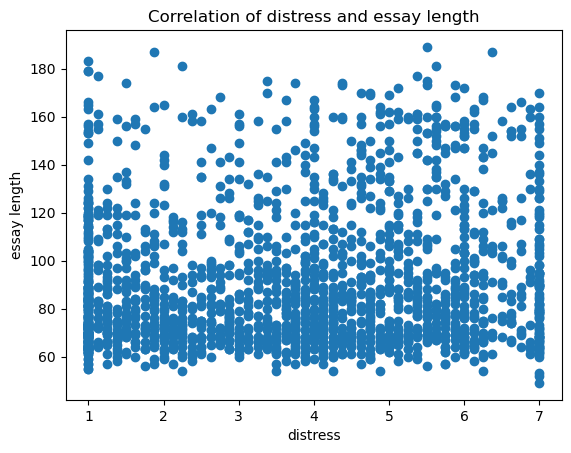

In [40]:
plt.scatter(joined.distress, joined.essay_len)
plt.title('Correlation of distress and essay length')
plt.xlabel('distress')
plt.ylabel('essay length')

### Correlate all variables

In [41]:
thresh = 0.1  # threshold to highlight correlations, set to 0 means looking at all data points
corr_table = joined.corr()
corr_table.where(np.abs(corr_table) >= thresh, '-')

,article_id,empathy,distress,empathy_bin,distress_bin,gender,education,race,age,income,...,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern,article_len,essay_len
article_id,1.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.113445
empathy,-,1.0,0.450938,0.846136,0.378659,-,-,-,-,-,...,0.113773,0.209026,0.243257,0.103789,0.228567,-,0.161712,0.299363,-,0.127854
distress,-,0.450938,1.0,0.382185,0.860048,-,-,-,-,-,...,-,0.124056,0.12659,-,0.126524,0.189525,0.120541,0.198645,-,0.139509
empathy_bin,-,0.846136,0.382185,1.0,0.362133,-,-,-,-,-,...,-,0.170608,0.189598,-,0.203973,-,0.131431,0.235817,-,-
distress_bin,-,0.378659,0.860048,0.362133,1.0,-,-,-,-,-,...,-,-,-,-,-,0.155334,-,0.130349,-,0.146905
gender,-,-,-,-,-,1.0,-,-,-,-,...,-,-,0.197429,-0.127292,0.120141,-,0.127233,0.178487,-,-
education,-,-,-,-,-,-,1.0,-,-,-,...,-,-,-,-,-,-0.104121,-,-0.102738,-,-
race,-,-,-,-,-,-,-,1.0,-0.199783,0.11291,...,-,-,-0.113082,-,-,-,-,-,-,-
age,-,-,-,-,-,-,-,-0.199783,1.0,-,...,-,-,0.146206,0.124038,-,-0.19048,-,-,-,0.167367
income,-,-,-,-,-,-,-,0.11291,-,1.0,...,-,-,-,-,-,-,-,-,-,-


## Desciptives for Data

In [42]:
print('Training data shape:', data_train.shape[0])
print('Dev data shape:', data_dev.shape[0])

Training data shape: 1860
Dev data shape: 270


### Boxplot: empathy and distress

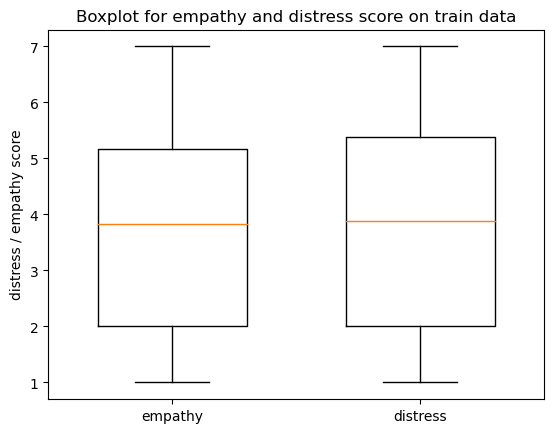

In [43]:
plt.boxplot(data_train[['empathy', 'distress']], widths=0.6, labels=['empathy', 'distress'])
plt.title('Boxplot for empathy and distress score on train data')
plt.ylabel('distress / empathy score')
plt.show()

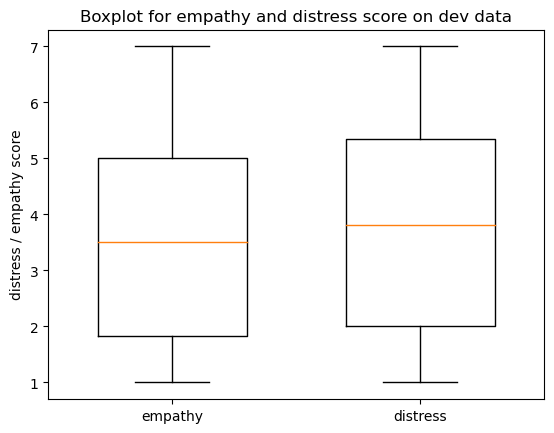

In [44]:
plt.boxplot(data_dev[['empathy', 'distress']], widths=0.6, labels=['empathy', 'distress'])
plt.title('Boxplot for empathy and distress score on dev data')
plt.ylabel('distress / empathy score')
plt.show()

In [45]:
# difference of mean on train and dev data
data_train[['empathy', 'distress']].mean() - data_dev[['empathy', 'distress']].mean()

empathy     0.141875
distress   -0.041570
dtype: float64

In [46]:
# difference of median on train and dev data
data_train[['empathy', 'distress']].median() - data_dev[['empathy', 'distress']].median()

empathy     0.3330
distress    0.0625
dtype: float64

In [47]:
# difference of mean of empathy and distress in train data
data_train[['empathy']].mean().item() - data_train[['distress']].mean().item()

-0.031200000000000117

In [48]:
# difference of mean of empathy and distress in train data
data_dev[['empathy']].mean().item() - data_dev[['distress']].mean().item()

-0.2146444444444442

### Distribution: empathy and distress

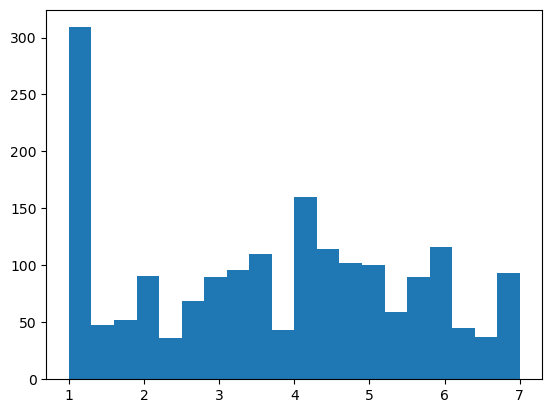

In [49]:
plt.hist(data_train['empathy'], bins=20)
plt.show()

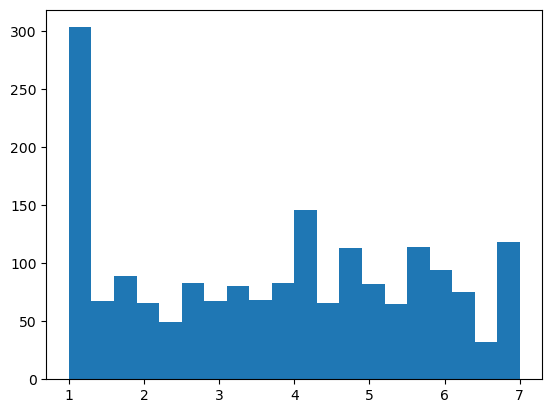

In [50]:
plt.hist(data_train['distress'], bins=20)
plt.show()

### Mean

In [51]:
data_train.drop(columns=['article_id', 'gender','education', 'race']).mean()

/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_30196/4117380871.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_train.drop(columns=['article_id', 'gender','education', 'race']).mean()


empathy                              3.699916
distress                             3.731116
empathy_bin                          0.492473
distress_bin                         0.486559
age                                 35.317204
income                           57874.973118
personality_conscientiousness        5.555108
personality_openess                  5.201613
personality_extraversion             3.819892
personality_agreeableness            5.352151
personality_stability                4.950269
iri_perspective_taking               3.781879
iri_personal_distress                2.584892
iri_fantasy                          3.504594
iri_empathatic_concern               3.772634
dtype: float64

### Standard deviation

In [52]:
data_train.drop(columns=['article_id', 'gender','education', 'race']).std()

/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_30196/2116255607.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_train.drop(columns=['article_id', 'gender','education', 'race']).std()


empathy                              1.825406
distress                             1.891517
empathy_bin                          0.500078
distress_bin                         0.499954
age                                 10.130744
income                           64680.056724
personality_conscientiousness        1.314176
personality_openess                  1.352760
personality_extraversion             1.875590
personality_agreeableness            1.375424
personality_stability                1.622139
iri_perspective_taking               0.786226
iri_personal_distress                0.934901
iri_fantasy                          0.841145
iri_empathatic_concern               0.927051
dtype: float64

### Median

In [53]:
data_train.drop(columns=['article_id', 'gender','education', 'race']).median()

/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_30196/778282504.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_train.drop(columns=['article_id', 'gender','education', 'race']).median()


empathy                              3.833
distress                             3.875
empathy_bin                          0.000
distress_bin                         0.000
age                                 33.000
income                           50000.000
personality_conscientiousness        6.000
personality_openess                  5.500
personality_extraversion             4.000
personality_agreeableness            5.500
personality_stability                5.500
iri_perspective_taking               3.857
iri_personal_distress                2.571
iri_fantasy                          3.571
iri_empathatic_concern               3.857
dtype: float64

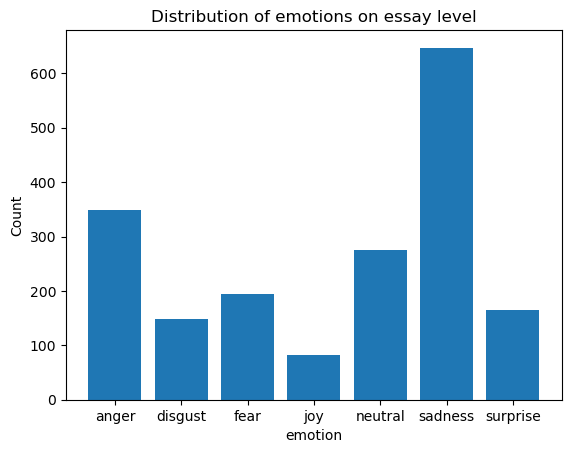

In [54]:
emotion_count = data_train.groupby('emotion').size()
emotion_labels = emotion_count.index.to_list()
plt.bar(range(len(emotion_count)), emotion_count)
plt.xticks(range(len(emotion_labels)), emotion_labels)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.title('Distribution of emotions on essay level')
plt.show()

In [55]:
data_train.groupby('emotion').mean()[['empathy', 'distress', 'empathy_bin', 'distress_bin']]

,empathy,distress,empathy_bin,distress_bin
emotion,,,,
anger,3.053971,3.646132,0.346705,0.461318
disgust,3.363530,4.077181,0.409396,0.563758
fear,3.480253,3.802191,0.422680,0.489691
joy,4.044683,2.987805,0.573171,0.317073
neutral,3.638796,3.481364,0.498182,0.447273
sadness,4.280535,4.018547,0.627512,0.545595
surprise,3.279470,3.169970,0.378049,0.384146


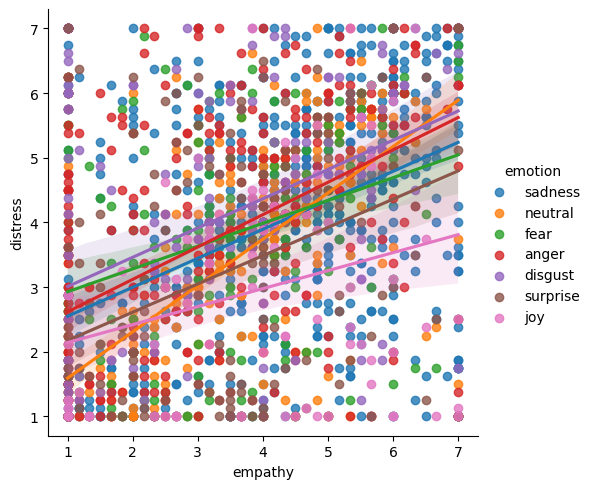

In [56]:
# the plot looks a little bit too messy, but we see difference in joy (joy is also under represented)
sns.lmplot(x="empathy", y="distress", data=data_train, hue="emotion")

### Correlation mean empathy / distress in answers

In [57]:
person_emp_dis_means = data_train[['empathy', 'distress', 'response_id', 'iri_empathatic_concern', 'iri_personal_distress']].groupby('response_id').mean()
person_emp_dis_means[:5]

,empathy,distress,iri_empathatic_concern,iri_personal_distress
response_id,,,,
R_03ql4LGD9I0cM7f,4.9334,4.325,3.571,2.143
R_088bdUkTs4jYl7b,3.2000,3.500,5.000,1.000
R_0CE9rf8V9zj643T,3.3664,3.300,4.143,4.429
R_0OePPQQ0Eu8vF3X,3.8000,5.800,5.000,1.571
R_0e3M54QcgpFMC3v,2.8334,3.025,4.857,2.143



 mean distress and mean empathy 
 r: 0.5851 
 p: 0.00000000


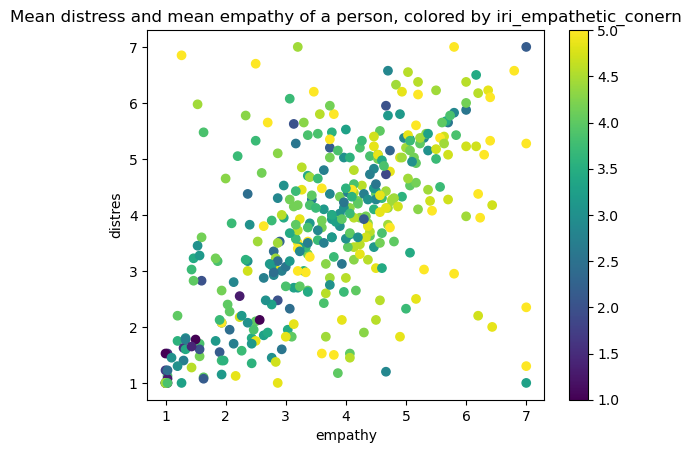

In [58]:
plt.scatter(person_emp_dis_means.empathy, person_emp_dis_means.distress, c=person_emp_dis_means.iri_empathatic_concern)
plt.colorbar()
plt.title('Mean distress and mean empathy of a person, colored by iri_empathetic_conern')
plt.xlabel('empathy')
plt.ylabel('distres')
r, p = pearsonr(person_emp_dis_means['empathy'], person_emp_dis_means['distress'])

print('\n mean distress and mean empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))


 mean distress and mean empathy 
 r: 0.5851 
 p: 0.00000000


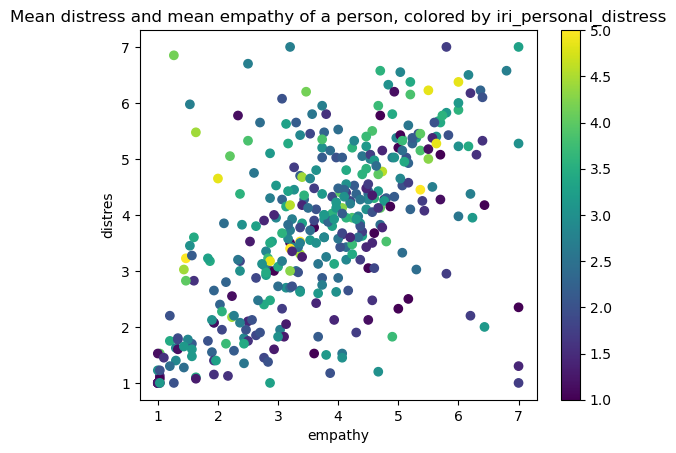

In [59]:

plt.scatter(person_emp_dis_means.empathy, person_emp_dis_means.distress, c=person_emp_dis_means.iri_personal_distress)
plt.colorbar()
plt.title('Mean distress and mean empathy of a person, colored by iri_personal_distress')
plt.xlabel('empathy')
plt.ylabel('distres')
r, p = pearsonr(person_emp_dis_means['empathy'], person_emp_dis_means['distress'])

print('\n mean distress and mean empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))

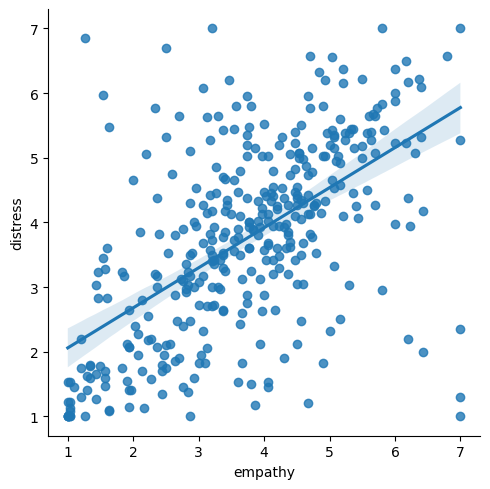

In [60]:
# source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html
ax = sns.lmplot(x="empathy", y="distress", data=person_emp_dis_means)

## Demographic data
* For dev data: mean of distress differs much more for male and female (3.478333 vs 4.198913). For train data it is 3.649369 vs 3.838081
* no huge corrlelation between age, income, empathy and distress

In [61]:
data_train[['age', 'income', 'empathy', 'distress']].corr()

,age,income,empathy,distress
age,1.000000,-0.009432,0.020449,-0.070702
income,-0.009432,1.000000,0.039843,0.041441
empathy,0.020449,0.039843,1.000000,0.450938
distress,-0.070702,0.041441,0.450938,1.000000


In [62]:
def count(x):
    return len(x)

In [63]:

pd.pivot_table(data_train, values=['empathy', 'distress'], index='gender', aggfunc=[np.mean, np.std, np.median, count])

mean                 std             median            count  \
        distress   empathy  distress   empathy distress empathy distress   
gender                                                                     
1       3.649369  3.681315  1.863473  1.759132    3.875   3.833      990   
2       3.838081  3.734117  1.917609  1.896641    3.875   3.833      860   
5       2.625000  2.600000  1.808545  1.837873    2.000   2.000       10   

                
       empathy  
gender          
1          990  
2          860  
5           10

In [64]:
pd.pivot_table(data_dev, values=['empathy', 'distress'], index='gender', aggfunc=[np.mean, np.std, np.median, count])

mean                 std             median            count  \
        distress   empathy  distress   empathy distress empathy distress   
gender                                                                     
1.0     3.478333  3.614480  1.819321  1.876896    3.625   3.667      150   
2.0     4.198913  3.539113  2.020855  1.860013    4.625   3.500      115   
5.0     2.800000  2.300200  1.248749  0.931003    2.375   2.667        5   

                
       empathy  
gender          
1.0        150  
2.0        115  
5.0          5

## Article 
### How much empathy or distress is a article eliciting? Can we use this as a feature maybe? 
Would this be overfitting the emp data too much as this feature would have information about the solution of this article in there?

In [65]:
joined_art = data_train.join(articles.set_index('article_id'), on='article_id')

In [66]:
def count(x):
    return len(x)
    
pivot_art = pd.pivot_table(joined_art, values=['empathy', 'distress'], index='article_id', aggfunc=[np.mean, np.std, np.median, count])
pivot_art[:30]

mean                 std             median            count  \
            distress   empathy  distress   empathy distress empathy distress   
article_id                                                                     
1           1.416667  2.833333  0.438986  2.362908   1.3750  2.0000        3   
2           3.600000  4.100000  0.985837  1.336559   3.1250  4.5000        5   
3           3.750000  5.500000  0.935414  0.805307   3.6250  5.2500        4   
4           2.250000  3.333400  1.750000  2.383386   1.2500  3.1670        5   
5           3.803571  4.309429  1.567670  1.281687   3.7500  5.0000        7   
6           4.250000  5.333333  2.750000  2.333071   4.2500  6.3330        3   
7           4.000000  4.041750  2.457980  2.450913   4.0000  4.0835        4   
8           4.575000  3.733400  2.176939  0.732170   5.0000  4.0000        5   
9           5.075000  5.333200  0.699330  1.874730   5.5000  5.8330        5   
10          3.125000  3.533400  1.595893  1.647370   2.7500  3.5000        5   
11          5.400000  4.033400  0.782624  1.126842   5.3750  4.0000        5   
12          1.979167  3.416667  1.038077  1.522965   1.6875  4.2500        6   
13          4.725000  4.066800  1.254367  1.535028   4.6250  4.6670        5   
14          3.781250  3.458500  2.527711  2.258162   3.9375  3.3335        4   
15          3.895833  4.055500  1.535856  0.750358   4.1875  3.7500        6   
16          1.775000  3.233400  0.945384  2.139526   1.5000  2.5000        5   
17          4.666667  2.611000  1.448778  1.931541   5.3750  1.6670        3   
18          4.375000  4.000000  1.603219  1.637130   4.6250  4.0000        5   
19          5.225000  4.900000  0.831039  0.878746   5.6250  5.0000        5   
20          3.325000  2.500000  2.008964  1.572401   3.0000  2.3330        5   
21          3.950000  2.833400  1.140860  0.634801   3.6250  2.8330        5   
22          3.500000  3.111333  2.384848  2.084058   3.7500  3.1670        3   
23          4.031250  4.291750  1.727157  0.864522   4.6250  4.1670        4   
25          4.854167  3.611167  0.976014  0.360082   4.8125  3.5835        6   
26          3.475000  2.500200  1.818739  1.779583   2.8750  1.6670        5   
27          4.325000  3.600200  1.410341  1.872997   4.6250  3.6670        5   
28          6.375000  6.222333  0.780625  0.947521   6.6250  6.5000        3   
29          4.625000  3.944667  1.068000  1.493920   4.5000  3.1670        3   
30          1.625000  1.777667  0.544862  0.385093   1.8750  2.0000        3   
31          4.062500  5.027833  1.860360  0.499203   4.1250  5.0000        6   

                    
           empathy  
article_id          
1                3  
2                5  
3                4  
4                5  
5                7  
6                3  
7                4  
8                5  
9                5  
10               5  
11               5  
12               6  
13               5  
14               4  
15               6  
16               5  
17               3  
18               5  
19               5  
20               5  
21               5  
22               3  
23               4  
25               6  
26               5  
27               5  
28               3  
29               3  
30               3  
31               6

In [67]:
pivot_art_no_nan = pivot_art.dropna()

Text(0.5, 1.0, 'Relation of STD and mean of the articles \n colored by the amount of data available for a single point')

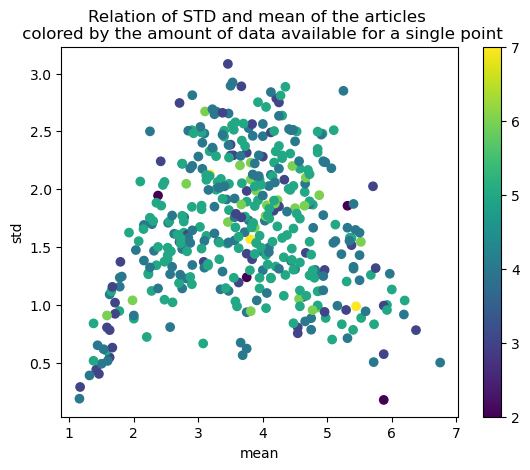

In [68]:
y = 'std'
x = 'mean'
# colors = np.array(['linen', 'bisque', 'wheat', 'orange', 'coral', 'oranged', 'firebrick', 'sienna', 'black'])
#print(type(colors[pivot_art_no_nan['count']['distress'].to_numpy()]))
plt.scatter(pivot_art_no_nan[x]['distress'], pivot_art_no_nan[y]['distress'], c = pivot_art_no_nan['count']['distress'], cmap='viridis')
plt.colorbar()
plt.ylabel(y)
plt.xlabel(x)
plt.title('Relation of STD and mean of the articles \n colored by the amount of data available for a single point')

In [69]:
pivot_art_no_nan = pivot_art.dropna()
r, p = pearsonr(pivot_art_no_nan['count']['distress'].to_numpy(), pivot_art_no_nan['std']['distress'].to_numpy())
print(r)
print(p)

0.06205915200598091
0.2065271922664527


In [70]:
print(pivot_art['std']['empathy'].mean())
print(pivot_art['std']['distress'].mean())
print(pivot_art['std']['empathy'].std())
print(pivot_art['std']['distress'].std())

1.5858063790779098
1.6640420722833427
0.5813241638181993
0.5932335730219216


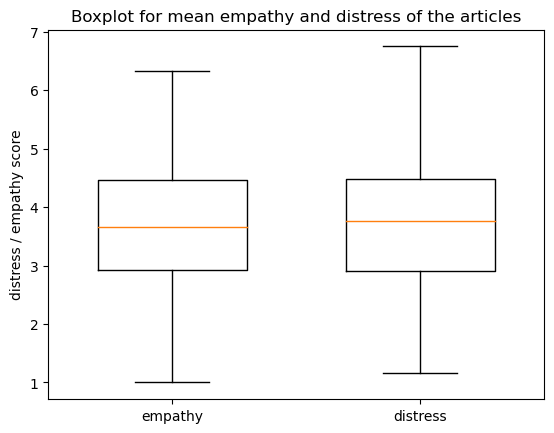

In [71]:
plt.boxplot([pivot_art_no_nan['mean']['empathy'], pivot_art_no_nan['mean']['distress']], widths=0.6, labels=['empathy', 'distress'])
plt.title('Boxplot for mean empathy and distress of the articles')
plt.ylabel('distress / empathy score')
plt.show()